# Explore here

In [2]:
import pandas as pd
# URL del dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
# Cargar los datos
df = pd.read_csv(url)

# Ver los primeros registros
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


## EDA

In [3]:
# Info general
print(df.info())

# Descripción estadística
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

In [4]:
print(df.isnull().sum())  # Muestra cuántos valores nulos hay por columna

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


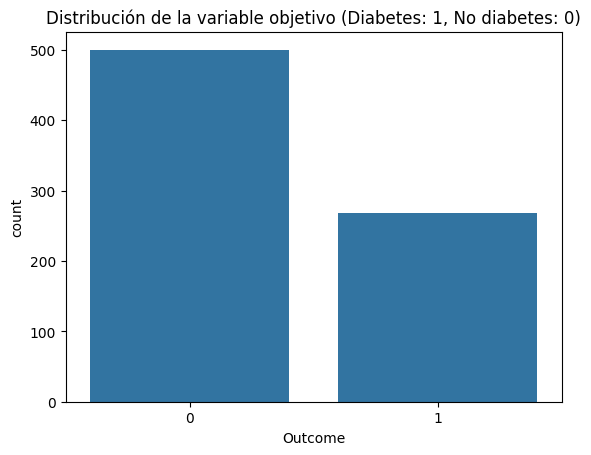

In [5]:
# Revisar la distribución de la variable objetivo

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["Outcome"])
plt.title("Distribución de la variable objetivo (Diabetes: 1, No diabetes: 0)")
plt.show()

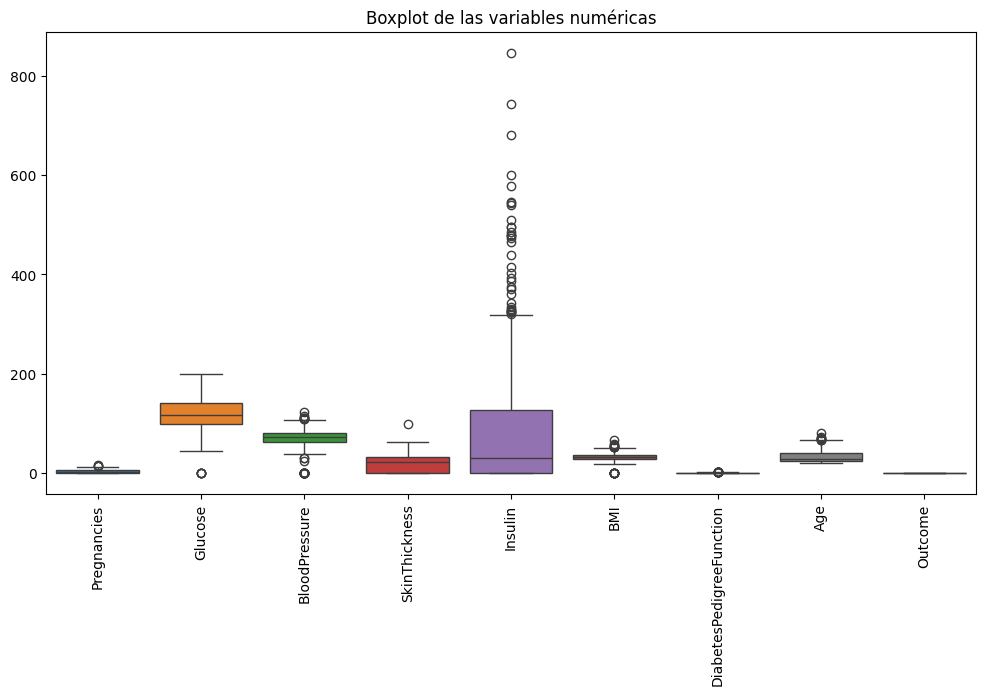

In [6]:
# Reviso outliers

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot de las variables numéricas")
plt.show()

### Empiezo a armar el modelo

In [7]:
X = df.drop(columns=["Outcome"])  # Variables predictoras
y = df["Outcome"]  # Variable objetivo

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Creamos el modelo con hiperparámetros básicos
modelo = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)

# Entrenamos
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [10]:
y_pred = modelo.predict(X_test)

### Evaluamos el modelo

In [11]:
from sklearn.metrics import accuracy_score, classification_report

# Exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Reporte de métricas (Precisión, Recall, F1-Score)
print(classification_report(y_test, y_pred))

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       100
           1       0.70      0.70      0.70        54

    accuracy                           0.79       154
   macro avg       0.77      0.77      0.77       154
weighted avg       0.79      0.79      0.79       154



### Hiperparametrización

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definir los valores a probar
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# Crear el modelo base
modelo = DecisionTreeClassifier(random_state=42)

# GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar con el mejor modelo
mejor_modelo = grid_search.best_estimator_
y_pred_mejor = mejor_modelo.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_mejor))

Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.75      0.85      0.79       100
           1       0.62      0.46      0.53        54

    accuracy                           0.71       154
   macro avg       0.69      0.66      0.66       154
weighted avg       0.70      0.71      0.70       154



##### Matriz de Confusión

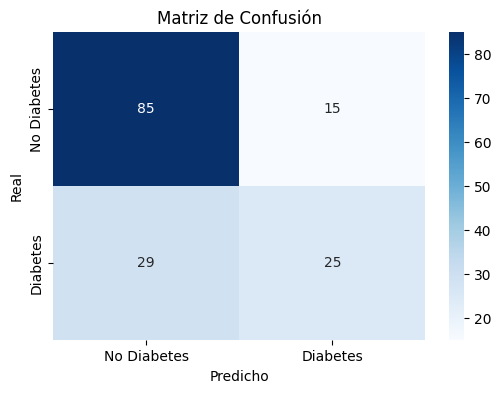

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_mejor)

# Graficarla
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

#### Curva ROC y AUC

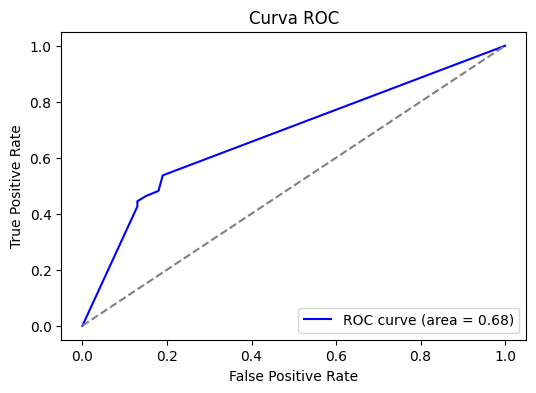

In [14]:
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de predicción
y_probs = mejor_modelo.predict_proba(X_test)[:, 1]

# Calcular ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea base
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

### Guardo el modelo entrenado

In [15]:
import joblib

# Guardamos el modelo
joblib.dump(mejor_modelo, "modelo_diabetes.pkl")
print("Modelo guardado como 'modelo_diabetes.pkl'")

Modelo guardado como 'modelo_diabetes.pkl'
